# Playground 10:  Segmentation workflow for Nucleus

This notebook contains the workflow for Nucleus, and serves as a starting point for developing a classic segmentation workflow if your data is Nucleus.

Key steps of the workflows:

* Auto-Contrast intensity normalization
* Edge preserving smoothing
* Intensity based thresholding
* Levelset based thresholding

In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage, omeTifWriter                             

# function for core algorithm
from scipy.ndimage.morphology import binary_fill_holes,binary_dilation, binary_closing
from aicssegmentation.core.utils import hole_filling, levelset_segmentation, fast_marching_levelset_segmentation
from aicssegmentation.core.pre_processing_utils import intensity_normalization, edge_preserving_smoothing_3d, background_sub
from skimage.morphology import remove_small_objects, ball, disk, erosion, dilation 
from skimage.filters import threshold_otsu

## Loading the data

In [2]:
FILE_NAME = '../../data/NUC/original/3500000959_100X_20170609_1-Scene-4-P4-E04.ome.tiff'
reader = AICSImage(FILE_NAME) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

(1, 4, 65, 624, 924)


## Preview of the image

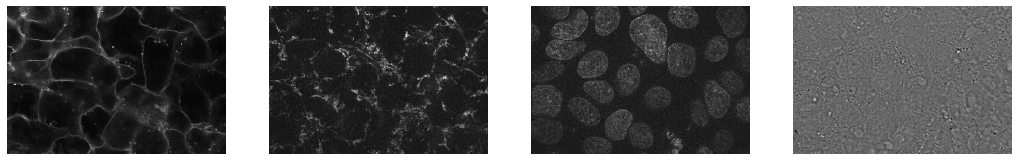

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [4]:
#####################
structure_channel = 2
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF3; proxy o…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * Parameter for NUC:  `intensity_scaling_param = [0.5, 15]`


* **Smoothing** 

    Edge preserving filter is used to preserve the boundary of the nucleus. It is important to keep high contrast between the boundary and background to achieve a good initial contour that used for levelset segmentation.

In [5]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [20,5]
################################
# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# background substraction
strucut_img = background_sub(struct_img, 50)

# smoothing with edge preserving filter filter
structure_img_smooth = edge_preserving_smoothing_3d(struct_img)

intensity normalization: normalize into [mean - 20 x std, mean + 5 x std] 
intensity normalization completes


In [6]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF3; proxy o…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = `#### If the contrast looks too off, you can play with the normalization parameters

* **segmentation seed** 

    Level-set based segmentation requires initial contour for segmentation. Initial contour can be acheived by computing distance transform from seed's boundary. Smoothed image go through intensitive level segmentation (Otsu), removing hall, and dilation. Depends on the image and target sturcutre, tune parameters for pre-processing steps. Primary goal for this step is to acquire the largest segmentation seed possible. Adjust `threshold_factor` so that seed covers all the cells

In [7]:
# intensity level segmentation 
thresh = threshold_otsu(structure_img_smooth)
threshold_factor = 0.888
seed = structure_img_smooth > thresh * threshold_factor

# final pre-processing to get seed
seed = remove_small_objects(seed>0, min_size=2500, connectivity=1, in_place=False)
seed = binary_closing(seed, structure=ball(4))
seed = hole_filling(seed, 200, 1200, fill_2d=False)

In [8]:
view(single_fluorescent_view(seed))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF3; proxy o…

### Step 2: Core Algorithm

#### step 2.1: Level-set based segmentation

Level-set based segmentation can handle topological change better and robust to noise than intensity level based segmentation. It models contour implicitly therefore merge and split between curvatures does not have to be handled explicitly. The algorithm performs numerical optimization to find optimal countour that can segment object from background effectively.

These are the parameters:
* `niter`: number of iteration for levelset segmentation to evolve.
* `max_error`:RMS error that decide which the filter should stop. This is convergence criterion. When increased, the algorithm will converge faster but will have less accurate segmentation result. Value in range [0,1] is recommended.
* `epsilon`: Regularize the width of Heaviside function. It is in the range [1,inf]. For higher resolution set `epsilon` to 2 or 3.
* `curvature_weight`: Scales all curvature weight values which affects curve propagation. Increasing `curvature weight` allows algorithm to segment boundary better. It is in range [0.0, inf]. 
* `smoothing_weight`: Weight of laplacian smoothing term in the range [0.0, inf].


Parameter for NUC: `niter`:25, `max_error`: 0.725, `epsilon`:1, `curvature_weight`:8.0, `smoothing_weight`=2.0

In [9]:
final_seg = levelset_segmentation(structure_img_smooth, 
                                  seed, 
                                  niter=25,
                                  max_error=0.725,
                                  epsilon=1, 
                                  curvature_weight=8.0, 
                                  smoothing_weight=2.0)

In [10]:
view(single_fluorescent_view(final_seg))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF3; proxy o…